# Introduction

We're dealing with two datasets of red and white wines and their chemical and pyscial properties, each labeled with a quality score. The goal here is to develop a classificator to output the estimated quality score for previously unseen records.

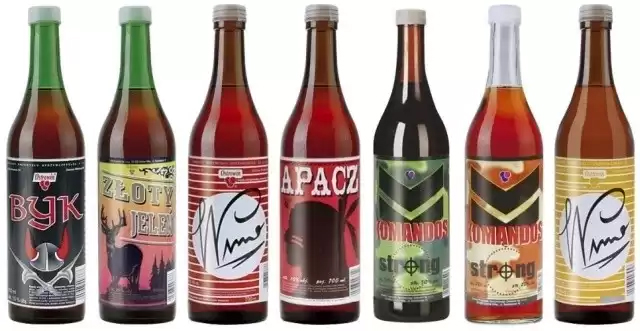

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/datacourage_wine /mydrive

# navigate to the working directory
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/datacourage_wine


## Libraries & functions
Let's now import the necessary libraries and function we're gonna use in this notebook.

### General
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `stats` - statistical functions
- `timeit` - cell runtime check
- `re` - regular expression handling

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import timeit
import re

### Visualization
- `plotly.graph_objects` - Plotly graph object handling (with better control than `plotly.express`)
- `matplotlib.pyplot` - matplotlib plotting interface
- `plot_confusion_matrix` - confusion matrix plotting for evaluating classification accuracy

In [4]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

### Scikit-learn models
Various classification models of different types found in the sklearn framework.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Scikit-learn extra functions
Some extra scikit-learn functions for:

- data preprocessing
- model selection
- pipeline creation
- model evaluation

I'll also suppress some minor warnings not to obscure the results in the later sections.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline

# turn off warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Load data
Let's load data using `pd.read_csv` function. The file is not precisely comma-separated, so we need to change the separator object to semicolon using `sep` parameter and check the shape of the dataset.

## Red wine

In [7]:
df_red = pd.read_csv('winequality-red.csv', sep=';')
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
df_red.shape

(1599, 12)

## White wine

In [9]:
df_white = pd.read_csv('winequality-white.csv', sep=';')
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [10]:
df_white.shape

(4898, 12)

## Merge datasets
Even though the number of records in the white wine dataset is 3 times larger than red wines, the number of features in each dataset is equal, so we're free to combine the red and white wine datasets to have more observations and hopefully, a better generalizing estimator later on. Let's merge them using `pd.concat()` function.

Before doing so, let's add a `color` feature representing wine color.

In [11]:
# add color feature
df_red['color'] = 'red'
df_white['color'] = 'white'

# concatenate datasets and reset indexing
df = pd.concat([df_red, df_white], ignore_index=True) 
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## Rename columns
For a better readibility let's rename the columns and replace spaces with an underscore using regex `re.sub()` function.

In [12]:
# replace whitespaces
old_column_names = df.columns.values.tolist()
new_column_names = [re.sub('\s', '_', col_name) for col_name in old_column_names]

# rename column names
df.columns = new_column_names
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## Convert categorical values
In order for the algorithms to work properly we need to convert any categorical values in our datasets to dummy encoded columns. In our situation only `color` feature is not numerical. This could have as well been done at the very beginning but whatever ;)

In [13]:
df = pd.get_dummies(df, columns=['color'])
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1,0


# Data exploration
Once we have our data loaded and tidied-up let's do some exploratory data analysis.

## Values info
Let's print an overview of the type information in the DataFrame and find potential issues.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color_red             6497 non-null   uint8  
 13  color_white           6497 non-null   uint8  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 621.9 KB


The data seems to be really clean. There are no missing values in the dataset and the dtypes are very consistent, so we're good to go.

## Statistical info
Let's generate a DataFrame of statistical measures for each column to find potential issues. 

In [15]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000,1.000000


At the first glance it looks like there might be some possible outliers in various columns as some `min` and `max` values are quite distant from `mean` considering standard deviation values `std` (e.g. `residual_sugar` or `free_sulfur_dioxide`). Let's investigate further.

## Box plot
I'll use box plot to visual potential outliers in the dataset. You can change the feature to visualize using a dropdown menu.

To do so let's create:

1. A list of features to investigate (excluding wine colors and quality labels)
2. An initial data box plot using Plotly's `go.Box()` function.
3. A dropdown menu to update the graph to show other feature's box plot.
4. A layout object to specify figure's properties.
5. A figure object using `go.Figure()` to put everything together.

In [16]:
##################
# LIST OF FEATURES
##################

feature_list = [
                'fixed_acidity',
                'volatile_acidity',
                'citric_acid',
                'residual_sugar',
                'chlorides',
                'free_sulfur_dioxide',
                'total_sulfur_dioxide',
                'density',
                'pH',
                'sulphates',
                'alcohol' 
]

###############
# INITIAL DATA
###############

initial_data = [
        go.Box(
            y = df['fixed_acidity'],
            name = 'fixed_acidity',
            boxpoints='suspectedoutliers', # display outliers
            marker = dict(color='orange') # box color
            )
]

###############
# DROPDOWN MENU
###############

updatemenus = [
               dict(
                    buttons=list(
                        [
                         dict(
                             label=feat, # dropdown menu item name
                             method='update', #  modify data and layout attributes
                             args=[
                                   {'y': [df[feat]]}, # update y-axis data
                                   {'name': feat}, # update name
                                   {'name': feat} # update y-axis title
                                   ]
                              ) for feat in feature_list # for each feature
                         ]),
                    direction='down',
                    showactive=True,
                    x=0.5, # x positioning
                    xanchor='center',
                    y=1.07, # y positioning
                    yanchor='top'
                   )
              ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Box plot for:', x=0.5),
                   width=800,
                   height=800,
                   updatemenus=updatemenus               
                  )

fig = go.Figure(
    data=initial_data,
    layout=layout
)

fig.show()

As we can see there are definitely some outliers (e.g. `chlorides`, `residual_sugar` or `free_sulfur_dioxide`) in the dataset which can both negatively influence the performane of the model. I'll address the issue later on.

## Correlation heatmap
Let's investigate the correlation between the features. The further away the value is from 0, the more positively or negatively correlated the features are. I'll use Plotly's `go.Heatmap()` function to visualize it.

In [17]:
###############
# DATA
###############

data = go.Heatmap(
                    z=df.corr(), # compute correlation matrix
                    x=df.columns,
                    y=df.columns,
                    colorscale='RdBu',
                    reversescale=True # flip colorscale to reflect red(+), blue(-)
                   )                      

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Feature correlation heatmap', x=0.5),
                   width=800,
                   height=800
                  )

###############
# FIGURE
###############

fig = go.Figure(
                data=data,
                layout=layout
               )
fig.show()

We can see that the correlations between wine features in our dataset exist, however they are not too strong. The only strong relationships we can see are:

- positive correlation (0.72) between free and total sulfur dioxide,
- positive correlation (-0.67) between alcohol and density

These two can also mean some kind of colinearity, but as long as we're building a classifier, not a regressor, it shouldn't cause any problems.

## Label correlation
From the heatmap we can see that the correlation coefficient between the quality of the wine and alcohol content is the most positively correlated with each other, whereas density most negatively correlated. Let's see how other features influence the quality using visualizing a simple bar plot using `go.Bar()`. 

In [18]:
# compute correlation for label column and sort values
correlations = df.corr()['quality'].sort_values(ascending=False)

###############
# DATA
###############

data = [
        go.Bar(
            x=correlations.index,
            y=correlations.values,
            marker_color='orange',
    )
        ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Quality correlation', x=0.5),
                   xaxis=go.layout.XAxis(title='Feature name'),
                   yaxis=go.layout.YAxis(title='Correlation value'),
                   bargap=0.2,
                   width=800,
                   height=800
                  )

###############
# FIGURE
###############

fig = go.Figure(
    data=data,
    layout=layout
    )

fig.show()

As we can see alcohol has the largest positive correlation with quality, whereas density and volatile acidity influence the quality negatively the most.

## Feature distribution
Let's investigate the distribution of the feature observations whether we're dealing with normally distributed or skewed data. Using a dropdown menu you can change the feature to show.

In [19]:
###############
# DATA
###############

initial_data = [
        go.Histogram(
            x = df['fixed_acidity'],
            marker_color='orange',
            )
]

###############
# DROPDOWN MENU
###############

updatemenus = [
               dict(
                    buttons=list(
                        [
                         dict(
                             label=feat, # dropdown menu item name
                             method='update', #  modify data and layout attributes
                             args=[
                                   {'x': [df[feat]]}, # update y-axis data
                                   {'name': feat} # update y-axis title
                                   ]
                              ) for feat in feature_list # for each feature
                                ]),
                    direction='down',
                    showactive=True,
                    x=0.5, # x positioning
                    xanchor='center',
                    y=1.07, # y positioning
                    yanchor='top'
                   )
              ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Box plot for:', x=0.5),
                   xaxis=go.layout.XAxis(title='Feature value'),
                   yaxis=go.layout.YAxis(title='Number of observations'),
                   width=800,
                   height=800,
                   updatemenus=updatemenus               
                  )

###############
# FIGURE
###############

fig = go.Figure(
    data=initial_data,
    layout=layout
)

fig.show()

We can see that some of the features are quite significantly skewed (mostly right) (e.g. `residual_sugar`) from a normal distribution which due to data assymetry can lead to a model bias.

## Class balance
Another thing to check is the representation of each of the labels. Let's see if there're issues with the balance of the number of observations for each class which can cause issues with minority class detection of our classifier.

In [20]:
###############
# DATA
###############

data = [
        go.Histogram(
            x=df['quality'],
            xbins=dict(
                size=0.5
            ),
            marker_color='orange',
    )            
        ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text="Class distribution", x=0.5),
                   xaxis=go.layout.XAxis(title='Class name'),
                   yaxis=go.layout.YAxis(title='Number of observations'),
                   bargap=0.2,
                   width=800,
                   height=800
                  )

###############
# FIGURE
###############

fig = go.Figure(
    data=data,
    layout=layout
    )

fig.show()

There's a vast overrepresentation of 5, 6 and 7-rated wines (a total of a couple of thousand observations) whereas wines rated the lowest and the highest make only around 400 cases. There's a clear class imbalance, which will have to be addressed later on, even though it might be extremely difficult for the two least-represented classes: 3 and 9.

# Data preprocessing
Let's preprocess our dataset to get it ready for model building.

## Outliers
Outliers, meaning the observations which are significatly different from the rest of the data, can badly influence the performance of our classifier. 

To get rid of them I'll use Z-score which calculates the distance of the observation from the mean using a multiplication of standard devation. Most of the outliers are positioned more than three standard deviations away from the mean. The formula is:



$ Z_{score} = \frac{value - mean}{std}$

### Find outliers
To find outliers I'll go through each column of the DataFrame, calculate an absolute value of a z-score for all values and return a boolean filter Series (with index values inherited from the original Series) indicating `True` if the observation is an outlier (|z-score| < 3) and `False` otherwise.

I'll skip `quality` column to avoid getting rid of small classes.

In [21]:
# create a copy of the DataFrame
df_filter = df.copy()

for f in df.columns:  
  
  # skip label column
  if f == 'quality':
    df_filter[f] = False

  else:
    # calculate absolute z-score
    z_score = np.abs(stats.zscore(df[f]))

    # replace values with boolean values depending on a condition
    outliers = np.where(z_score>3, True, False)
    
    # return a new series with a correct indexing
    df_filter[f] = pd.Series(outliers, index=df[f].index)

df_filter.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False


### Drop outlier rows
Once we have a boolean DataFrame, we can use it to remove outliers from the original DataFrame. I'll use the tilde `~` operator in order to create a complementary DataFrame (flip True and False values). 

The filtering will result in `Nan` values instead of outliers. Then, I can get rid of the rows which contain any NaN values and reset the DataFrame index.

In [22]:
# filter DataFrame
df = df[~df_filter]

# drop NaN values
df.dropna(inplace=True)

# reset indexing
df.reset_index(drop=True, inplace=True)

df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1,0
1,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1,0
2,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1,0
3,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1,0
4,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,1,0


### Check shape
After filtering out outliers it's good to check if our dataset didn't shrink too much.

In [23]:
df.shape

(6009, 14)

We've lost around 7% of out data due to outlier removal. 

## Minority class
The least-represented class - 9. Has only 5 observations. Therefore it's not even suitable for future oversampling and cause some issues with the classifiers latern on. Therefore we'll get rid of it.

In [24]:
df = df[df['quality'] != 9]

## Features/labels split
Let's divide our dataset into features and labels.

In [25]:
X = df.drop('quality', axis=1)
y = df['quality']

## Standarization
Remembering the statistical exploration of our dataset we can say it doesn't contain standard normally distributed data, so we should standardize the features by removing the mean and scaling to unit variance. To do it I'll use sklearn's `StandardScaler()`

In [26]:
X = StandardScaler().fit(X).transform(X)

## Dataset split
Let's split the dataset into train and test sets to avoid any data leakage.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [28]:
X_train.shape

(4503, 13)

In [29]:
X_test.shape

(1501, 13)

# Model selection
Let's create a list of scikit-learn classifiers to test. I'll pick one most popular classifier for each  method:

- Ligistic Regression (linear models)
- K-nearest Neighbors (nearest neighbors algorithms)
- Decision Tree (decision trees)
- Random Forest (ensamble methods)
- SVC (support vector machines)
- Guassian NB (Naive Bayes)
- Linear Discriminant Analysis (discriminant analysis)

In [30]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Classifier': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis()
}

## Classification reports
For all above estimators let's print out detailed classification reports to see how they perform with our dataset.

- $ precision = \frac{TP}{TP+FP}$ - What proportion of positive predictions was actually correct?

- $ recall = \frac{TP}{TP+FN}$ - What proportion of actual positives was predicted correctly?

- $ f1_{score} = \frac{TP}{TP+\frac{1}{2}(FP+FN)}$ - What proportion of actual positives was predicted correctly?

- $ accuracy = \frac{correctpredictions}{all predictions}$ - What proportion of actual positives was predicted correctly?

- $ accuracy = \frac{correct predictions}{all predictions}$ - What proportion of actual positives was predicted correctly?

- $ macro_{avg} $ - Equally weighted average

- $ weighted_{avg} - $ Weighted average




In [31]:
for name, clf in classifiers.items():
  
  print(f'\n\nChecking {name} classifier:\n')
  
  # fit the model
  clf.fit(X_train, y_train)

  # predict labels for the test set
  preds = clf.predict(X_test)

  # print the classification report
  print(classification_report(y_test, preds, zero_division=0))



Checking Logistic Regression classifier:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.80      0.09      0.16        46
           5       0.56      0.63      0.59       470
           6       0.54      0.67      0.60       673
           7       0.50      0.24      0.33       255
           8       0.00      0.00      0.00        51

    accuracy                           0.54      1501
   macro avg       0.40      0.27      0.28      1501
weighted avg       0.52      0.54      0.51      1501



Checking K-Nearest Neighbors classifier:

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.17      0.09      0.12        46
           5       0.54      0.66      0.59       470
           6       0.57      0.57      0.57       673
           7       0.53      0.45      0.49       255
           8       0.46      0.12      0.19 

## Cross validation

In [32]:
# initiate empty DataFrame
classifiers_cv = pd.DataFrame()

for name, clf in classifiers.items():

  # fit the classifier
  start = timeit.default_timer()
  clf.fit(X_train, y_train)
  stop = timeit.default_timer()

  # calculate train, test and cv scores as well as runtime
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)
  score_cv = cross_val_score(
      clf,
      X_train,
      y_train,
      cv=5,
      scoring='accuracy'
      ).mean()
  runtime = stop-start

  # append calculated scores to the DataFrame
  classifiers_cv = classifiers_cv.append(
      {'classifier': name,
       'score_train': train_score,
       'score_test': test_score,
       'score_cv': score_cv,
       'runtime': runtime
      },
      ignore_index = True)

# display scores in a descending order
classifiers_cv.sort_values(by='score_cv', ascending=False)

,classifier,runtime,score_cv,score_test,score_train
3,Random Forest,0.941435,0.658449,0.698867,1.000000
2,Decision Tree,0.041627,0.577176,0.607595,1.000000
4,Support Vector Classifier,1.213191,0.568070,0.571619,0.607373
1,K-Nearest Neighbors,0.010139,0.553416,0.546969,0.701532
0,Logistic Regression,0.710928,0.549415,0.541639,0.555852
6,Linear Discriminant Analysis,0.011608,0.546970,0.543638,0.552521
5,Gaussian Naive Bayes,0.002426,0.439035,0.457029,0.452809


# Model evaluation
Looking at both classification reports as well as the cross validation scoring for all of the classifiers it looks like Random Forest classifier is significantly better than other methods, however it seems like it's overfitting. Let's dig deeper into it.

## Helper functions
Let's define a few functions to help us evaluate the classifier.

- `model_evaluation()` for cross-validation
- `confusion_matrix_plot()` for confusion matrix plotting
- `plot_learning_curve()` for learning curve plotting

In [33]:
def model_evaluation(estimator, parameters):

  # initiate a grid search object
  search = GridSearchCV(
      estimator,
      parameters,
      scoring='accuracy',
      cv=5,
      verbose=1,
      n_jobs=-1
      )
  
  # fit the model
  start = timeit.default_timer()
  search.fit(X_train, y_train)
  stop = timeit.default_timer()

  # extract the evaluation results for further use
  b_score = search.best_score_
  b_parameters = search.best_params_
  b_estimator = search.best_estimator_
  score_train = b_estimator.score(X_train, y_train)
  score_test = b_estimator.score(X_test, y_test)
  score_cv = cross_val_score(search, X_train, y_train, cv=5, scoring='accuracy').mean()
  runtime = stop-start

  evaluation_results = dict(runtime=runtime,
                            b_score=b_score,
                            b_parameters=b_parameters,
                            b_estimator=b_estimator,
                            score_test=score_test,
                            score_train=score_train,
                            score_cv=score_cv
                           )

  return evaluation_results

In [34]:
def confusion_matrix_plot(classifier):
  fig, (ax1, ax2) = plt.subplots(nrows=1,
                           ncols=2,
                           sharex=True,
                           sharey=True,
                           figsize=(20,10))
  plot_confusion_matrix(classifier, X_train, y_train, ax=ax1)
  plot_confusion_matrix(classifier, X_test, y_test, ax=ax2)

  plt.xticks(rotation=90) 
  ax1.set(title='Train set')
  ax1.tick_params(axis='x', labelrotation=90)
  ax2.set(title='Test set') 
  ax2.tick_params(axis='x', labelrotation=90)

  return plt.show()

In [35]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")


    return plt

## Basic model
First let's say how a out-of-box `RandomForestClassifier()` performs.

In [36]:
# initiate and fit the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Confusion matrix

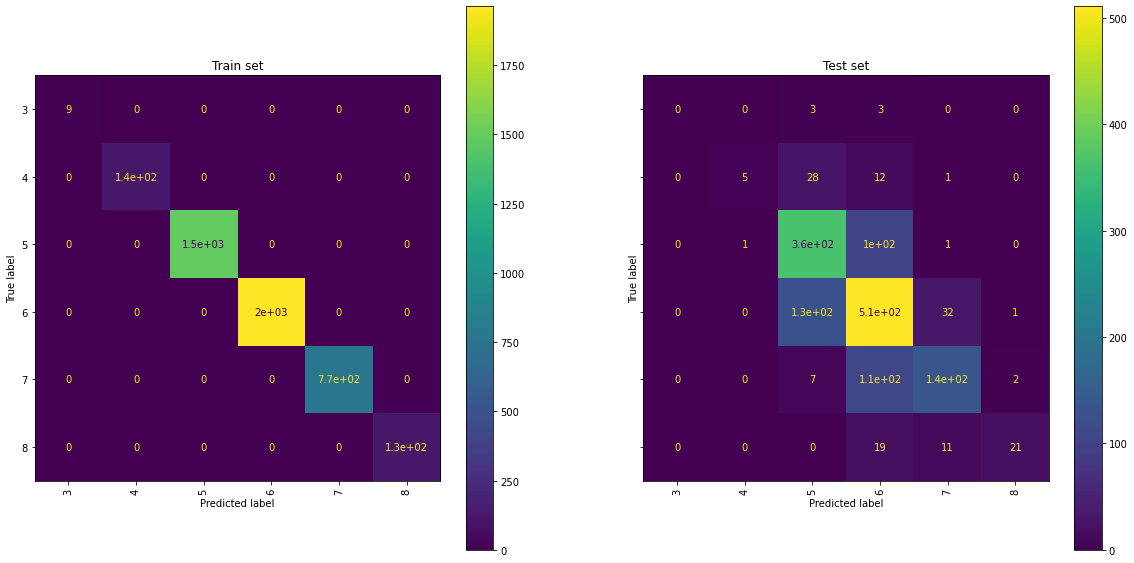

In [37]:
confusion_matrix_plot(clf)

As we could see previously the model is clearly overfitting - predicting perfectly on training data, but performing much worse on the test data.

### Learning curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

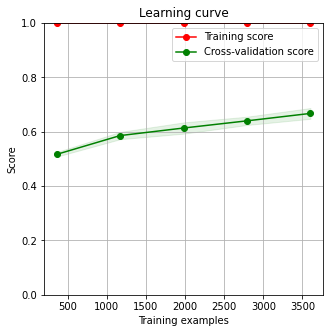

In [38]:
plot_learning_curve(
    clf,
    title='Learning curve',
    X=X_train,
    y=y_train,
    ylim=(0.0, 1.0),
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(.1, 1.0, 5)
    )

We can see that even though the model is over-fitting on train data, it's making a gradual progress on cross-validation score and generalizing quite well. It would be great

### Classification report

In [39]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.83      0.11      0.19        46
           5       0.69      0.78      0.73       470
           6       0.68      0.76      0.71       673
           7       0.75      0.54      0.63       255
           8       0.88      0.41      0.56        51

    accuracy                           0.69      1501
   macro avg       0.64      0.43      0.47      1501
weighted avg       0.70      0.69      0.68      1501



### ROC AUC scoring
Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) which a lot of time is a better indication of a good classification performance.

In [40]:
# calculate cross validation score with ROC AUC scoring
accuracy = cross_val_score(
    clf,
    X,
    y,
    scoring='roc_auc_ovr',
    cv=10
    )

print('Cross validation score with roc_auc_ovr scoring:', accuracy.mean())

cross validation score with roc_auc_ovr scoring 0.6932836504290443


In [41]:
# calculate probabilities
probabilities = clf.predict_proba(X_test)

# calculate roc_auc score with multiclass parameter (One vs Rest)
score = roc_auc_score(y_test, probabilities, multi_class='ovr')

print('ROC AUC score with multiclass parameter:', score)

roc_auc_score 0.8139033784008328


## Hyper-parameter tuning
Let's find the most optimal values for hyper-parameters of the model and try to increase the classification scores using exhaustive grid search `GridSearchCV()`.

I'll also check different values for `max_depth` and `class_weight` to check if it helps with overfitting of the data.

In [42]:
# # start runtime check
# start = timeit.default_timer()

# # create a dictionary of parameters to search through
# parameters = {
#     'n_estimators': [100, 200, 500],
#     'min_samples_split': [2, 3, 4],
#     'min_samples_leaf': [1, 2, 3],
#     'max_depth': [5, 10, 15, None],
#     'criterion': ['gini', 'entropy'],
#     'class_weight': ['balanced', None]
#              }

# # evalue the classifier using GridSearchCV
# evaluation_results = model_evaluation(RandomForestClassifier(), parameters)

# # print cell runtime
# stop = timeit.default_timer()
# print('Runtime: {} seconds.'.format(stop-start))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 57.4min finished


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.5min finished


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.7min finished


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.6min finished


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.1min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.6min finished


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 49.1min finished


Runtime: 18091.218635065 seconds.


In [43]:
# Fitting 5 folds for each of 432 candidates, totalling 2160 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.3s
# [Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.0min
# [Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  8.8min
# [Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 17.3min
# [Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 31.4min
# [Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 43.6min
# [Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 57.4min finished
# Fitting 5 folds for each of 432 candidates, totalling 2160 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.4s
# [Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
# [Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
# [Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.8min
# [Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 26.7min
# [Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.1min
# [Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.5min finished
# Fitting 5 folds for each of 432 candidates, totalling 2160 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.4s
# [Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
# [Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
# [Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.8min
# [Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 26.8min
# [Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.3min
# [Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.7min finished
# Fitting 5 folds for each of 432 candidates, totalling 2160 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.5s
# [Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
# [Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
# [Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.8min
# [Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 26.7min
# [Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.1min
# [Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.6min finished
# Fitting 5 folds for each of 432 candidates, totalling 2160 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.5s
# [Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.5min
# [Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.4min
# [Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 14.8min
# [Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 26.7min
# [Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.1min
# [Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 48.6min finished
# Fitting 5 folds for each of 432 candidates, totalling 2160 fits
# [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
# [Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.5s
# [Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min
# [Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  7.5min
# [Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 15.0min
# [Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 27.0min
# [Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 37.5min
# [Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 49.1min finished
# Runtime: 18091.218635065 seconds.

### Performance check
Let's check if the parameters found by `GridSearchCV()' helped with the performance of the model.

#### Initiate the model

In [44]:
# clf = evaluation_results['b_estimator']
# clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
clf = RandomForestClassifier(
    class_weight=None,
    criterion='entropy',
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500
    )

#### Confusion matrix

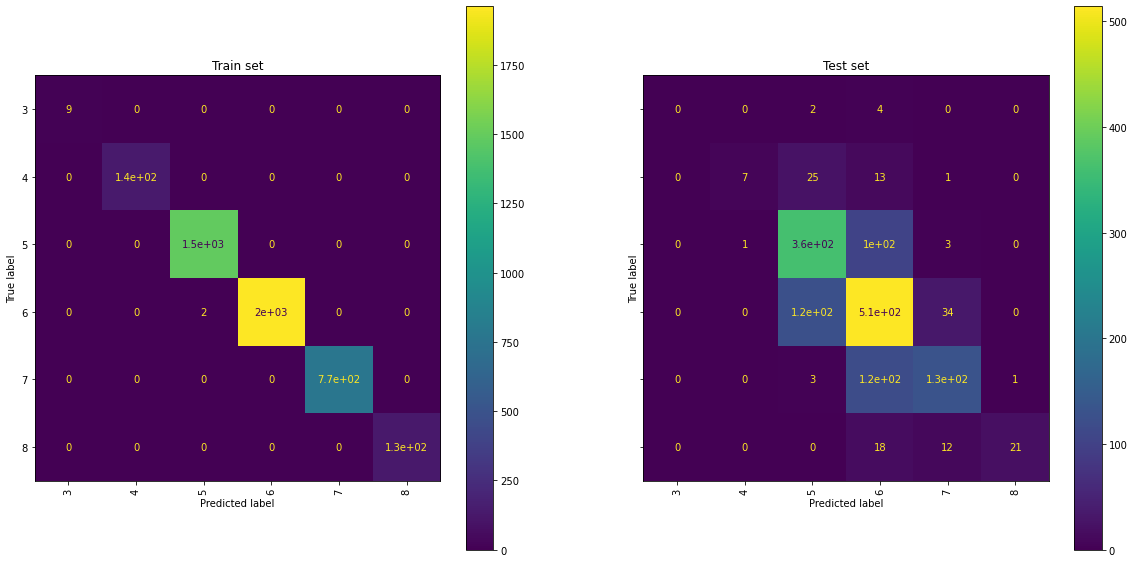

In [45]:
confusion_matrix_plot(clf)

#### Learning curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

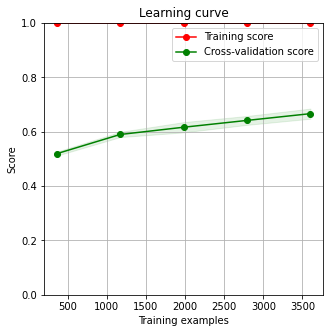

In [46]:
plot_learning_curve(
                    clf,
                    title='Learning curve',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

#### Classification report

In [47]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.88      0.15      0.26        46
           5       0.70      0.77      0.73       470
           6       0.66      0.76      0.71       673
           7       0.72      0.51      0.60       255
           8       0.95      0.41      0.58        51

    accuracy                           0.69      1501
   macro avg       0.65      0.44      0.48      1501
weighted avg       0.70      0.69      0.68      1501



In [48]:
accuracy = cross_val_score(
    clf,
    X,
    y,
    scoring='roc_auc_ovr',
    cv=10
    )
print('cross validation score with roc_auc_ovr scoring',accuracy.mean())

cross validation score with roc_auc_ovr scoring 0.6959221747299837


In [49]:
# Calculate roc_auc score with multiclass parameter
print('roc_auc_score', roc_auc_score(
    y_test,
    clf.predict_proba(X_test),
    multi_class='ovr'
    ))

roc_auc_score 0.8534371380942432


The hyper-parameter tuning didn't really help with the performance of the model that much. The scores are almost the same as with the out-of-box model.

## Feature importance
Let's see what are the importances of the features for the prediction. The higher the value is, the more important the feature is. Let's visualize it using plotly.

In [58]:
# extract feature importances from the classifier
importance = clf.feature_importances_

# extract the feature names
columns = X = df.drop('quality', axis=1).columns

# create a feature importance series
feature_importances = pd.Series(importance, index=columns).sort_values(ascending=False)

###############
# DATA
###############

data = [
        go.Bar(
            x=feature_importances.index,
            y=feature_importances.values,
            marker_color='orange',
    )
        ]

###############
# LAYOUT
###############

layout = go.Layout(
                   title=go.layout.Title(text='Feature importances', x=0.5),
                   xaxis=go.layout.XAxis(title='Feature name'),
                   yaxis=go.layout.YAxis(title='Importance value'),
                   bargap=0.2,
                   width=800,
                   height=800
                  )

###############
# FIGURE
###############

fig = go.Figure(
    data=data,
    layout=layout
    )

fig.show()

The most important feature to influence the quality prediction is `alcohol` ;)

## Resampling
Parameter tuning didn't really influence our model that much. However, we're dealing with imbalanced classes, so we can also try resampling the dataset to see if it helps the classifier.

I'll use oversampling technique to try to balance out the dataset.

In [79]:
# import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

# oversample the minority classes
over = RandomOverSampler(sampling_strategy='minority', random_state=0)
X_over, y_over = over.fit_resample(X_train, y_train)

# fit the classifier with the oversampled data
clf.fit(X_over, y_over)

# display the classification report
preds = clf.predict(X_test)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.86      0.13      0.23        46
           5       0.69      0.76      0.73       470
           6       0.66      0.76      0.70       673
           7       0.73      0.50      0.60       255
           8       0.91      0.41      0.57        51

    accuracy                           0.68      1501
   macro avg       0.64      0.43      0.47      1501
weighted avg       0.69      0.68      0.67      1501



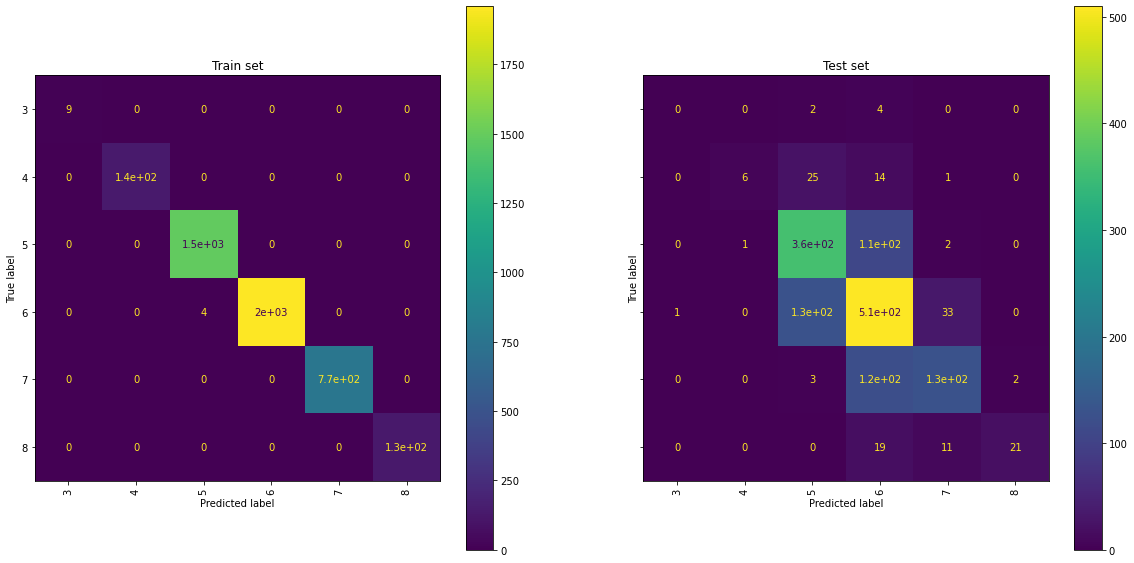

In [80]:
confusion_matrix_plot(clf)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

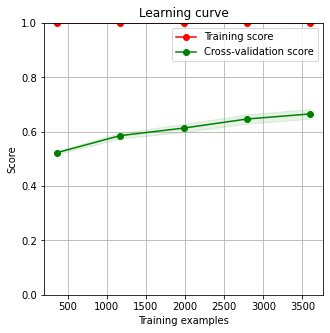

In [81]:
plot_learning_curve(
                    clf,
                    title='Learning curve',
                    X=X_train,
                    y=y_train,
                    ylim=(0.0, 1.0),
                    cv=5,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 5)
                   )

Even though we balanced out the dataset using oversample it didn't improve the performance of our model. It actually decreased it.

# Conclusion

1. DATA

For the task I have used both white and red wines datasets to have more observations to learn on.

The data was fairly clean so it didn't require too much preprocessing. There were only some issues with outliers and skewness of some features. This was later handled with standarization and outlier dropping using z-score.

2. MODEL

I've tried multiple classification methods to see which one performs the best with the dataset. It turned out that decision tree based models got the best scoring, especially Random Forest Classifier.

I evaluated the performance of the model using cross-validation, hyperparameter tuning, various metrics and scoring as well as using leaning curves. 
Additionally I addressed the class imabalance issue and used oversampling technique for the minority classes.

This part took a lot of time, however doesn't seem to have helped much with the performance which doesn't differ much from a deaful out-of-the-box Random Forest Classifier.

All in all we've ended up with quite well generalizing model, which could potentially be improved by feeding the model with more observations.

Cheers!

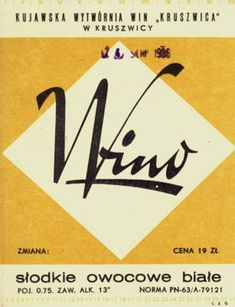